In [1]:
#| hide
# check if in colab and install package as needed
![ -e /content ] && ! pip show fastai-torchgeo && pip install git+https://github.com/butchland/fastai-torchgeo.git
![ -e /content ] && ! pip show nbdev && pip install nbdev

17.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
23.23s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


# EuroSAT Land Use/Land Cover (LULC) Classification Tutorial
> finetune a torchgeo pretrained resnet model on the torchgeo EuroSAT dataset for LULC

[![](https://raw.githubusercontent.com/butchland/fastai-torchgeo/master/assets/colab.svg)](https://colab.research.google.com/github/butchland/fastai-torchgeo/blob/master/nbs/tutorial/03-eurosat-classification.ipynb)

This is tutorial on finetuning a [pretrained torchgeo resnet model](https://torchgeo.readthedocs.io/en/stable/api/models.html#resnet) on the [torchgeo EuroSAT dataset](https://torchgeo.readthedocs.io/en/stable/api/datasets.html#eurosat)
using the [fastai](https://docs.fast.ai) framework.

> Note: this tutorial assumes _some_ familiarity with the fastai deep learning package and will focus on torchgeo integration.

## Installation 

Install the package

```bash
pip install git+https://github.com/butchland/fastai-torchgeo.git
```

## Import the packages and download the EuroSAT dataset 

In [3]:
import torch
from torchgeo.datasets import EuroSAT
from torchgeo.datamodules import EuroSATDataModule 
from torchgeo.models import ResNet50_Weights, resnet50

import fastai.vision.all as fv

from fastai_torchgeo.data import GeoImageBlock
from fastai_torchgeo.resnet import make_resnet_model, resnet_split

In [4]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: mps


## Create a fastai datablock and fastai dataloaders  

In [6]:
batch_size=64
num_workers = fv.defaults.cpus
dset_name = 'EuroSAT'

In [7]:
dblock = fv.DataBlock(blocks=(GeoImageBlock(), fv.CategoryBlock()),
                      get_items=fv.get_image_files,
                      splitter=fv.RandomSplitter(valid_pct=0.2, seed=42),
                      get_y=fv.parent_label,
                      item_tfms=fv.Resize(64),
                      batch_tfms=[fv.Normalize.from_stats(EuroSATDataModule.mean, EuroSATDataModule.std)],
                     )

In [8]:
cfg = fv.fastai_cfg()
data_dir = cfg.path('data')
dset_path = data_dir/dset_name

In [9]:
datamodule = EuroSATDataModule(root=dset_path, batch_size=batch_size, num_workers=num_workers, download=True)

In [10]:
%%time
datamodule.prepare_data()

CPU times: user 78.3 ms, sys: 16.5 ms, total: 94.8 ms
Wall time: 129 ms


Setting-up type transforms pipelines
Found 27000 items
2 datasets of sizes 21600,5400
Setting up Pipeline: partial
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: partial
    starting from
      /Users/wxmiked/.fastai/data/EuroSAT/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Highway/Highway_2044.tif
    applying partial gives
      GeoTensorImage of size 13x64x64
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /Users/wxmiked/.fastai/data/EuroSAT/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/Highway/Highway_2044.tif
    applying parent_label gives
      Highway
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (GeoTensorImage: torch.Size([13, 64, 64]), TensorCategory(3))


Found 27000 items
2 datasets of sizes 21600,5400
Setting up Pipeline: partial
Setting

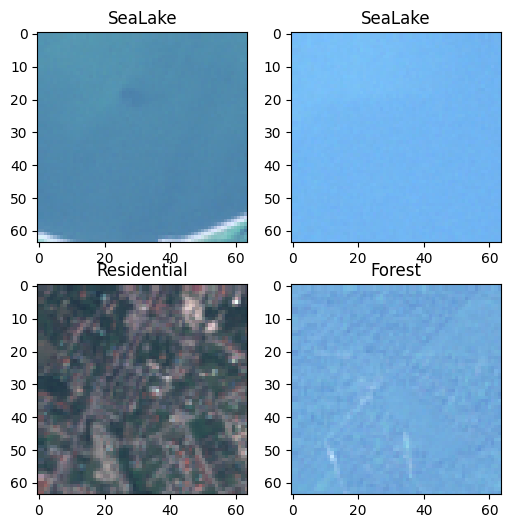

In [11]:
dblock.summary(dset_path, show_batch=True)

In [12]:
dls = dblock.dataloaders(dset_path, bs=batch_size, device='mps' if torch.backends.mps.is_available() else 'cpu')

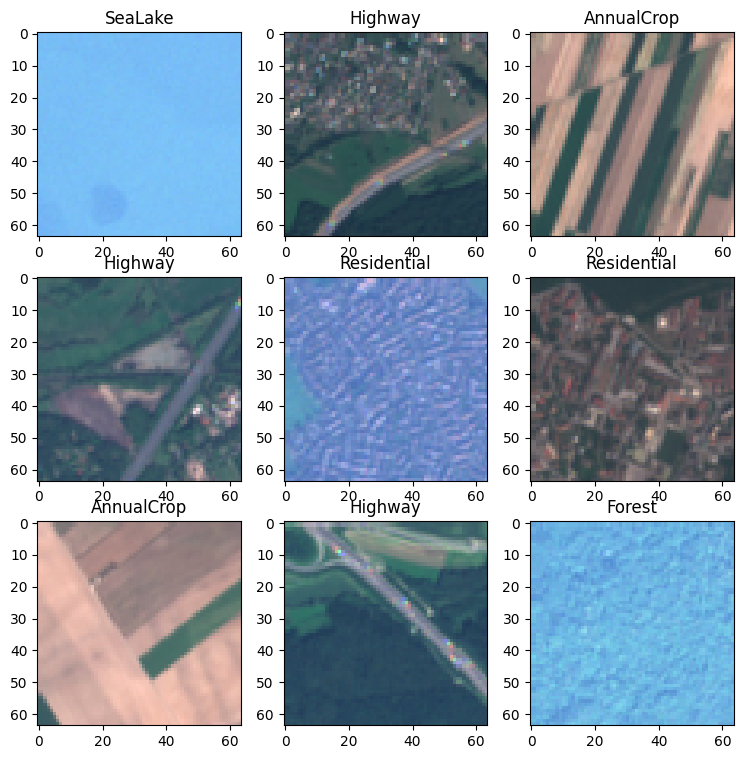

In [13]:
dls.show_batch()

## Download the torchgeo pretrained resnet model and prepare a fastai compatible model

In [14]:
pretrained = resnet50(ResNet50_Weights.SENTINEL2_ALL_MOCO, num_classes=10) # load pretrained weights

In [16]:
model = make_resnet_model(pretrained, n_out=10)

## Create a fastai learner

In [17]:
learn = fv.Learner(
    dls, 
    model,
    loss_func=fv.CrossEntropyLossFlat(),
    metrics=[fv.accuracy],
    splitter=resnet_split,
)
# freeze uses parameter groups created by `resnet_split` 
# to lock parameters of pretrained model except for the model head

learn.freeze()

In [18]:
# note: only head parameter group is trainable (except BatchNorm layers w/ch are always trainable)
learn.summary()

Sequential (Input shape: 64 x 13 x 64 x 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 32 x 32   
Conv2d                                    40768      False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 16 x 16   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                   

## Train the model

/Users/wxmiked/vscode-workspace/cannabis/cannabis-deforestation/.venv/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state 

SuggestedLRs(valley=0.0004786300996784121)

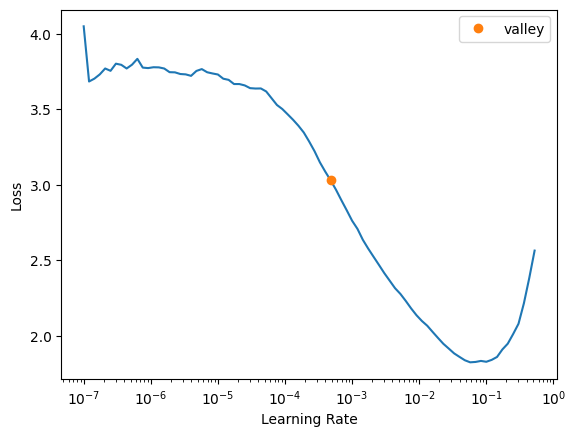

In [19]:
learn.lr_find()

In [20]:
from fastai.callback.tracker import SaveModelCallback
import numpy as np

In [22]:
print(f"Model device: {next(learn.model.parameters()).device}")
print(f"Data device: {learn.dls.device}")

Model device: mps:0
Data device: mps


In [21]:
learn.fine_tune(10, freeze_epochs=3, base_lr=7e-4, cbs=[SaveModelCallback(monitor='accuracy',fname='euronet-resnet50-stage1')])

epoch,train_loss,valid_loss,accuracy,time
0,0.522304,0.297258,0.907778,01:24
1,0.316234,0.235057,0.921667,01:23
2,0.245201,0.179878,0.940926,01:23


Better model found at epoch 0 with accuracy value: 0.9077777862548828.
Better model found at epoch 1 with accuracy value: 0.92166668176651.
Better model found at epoch 2 with accuracy value: 0.9409258961677551.


epoch,train_loss,valid_loss,accuracy,time
0,0.137860,0.132594,0.956111,01:34
1,0.091193,0.126636,0.961852,01:34
2,0.073052,0.141620,0.960000,01:34
3,0.048301,0.131717,0.962407,01:35
4,0.028266,0.121343,0.966296,01:35
5,0.024820,0.114712,0.966667,01:36
6,0.009628,0.112095,0.970926,01:35
7,0.005801,0.107946,0.972222,01:36
8,0.004367,0.112994,0.971296,01:38
9,0.002931,0.108366,0.972963,01:38


Better model found at epoch 0 with accuracy value: 0.9561111330986023.
Better model found at epoch 1 with accuracy value: 0.9618518352508545.
Better model found at epoch 3 with accuracy value: 0.9624074101448059.
Better model found at epoch 4 with accuracy value: 0.9662963151931763.
Better model found at epoch 5 with accuracy value: 0.9666666388511658.
Better model found at epoch 6 with accuracy value: 0.9709259271621704.
Better model found at epoch 7 with accuracy value: 0.9722222089767456.
Better model found at epoch 9 with accuracy value: 0.9729629755020142.


In [ ]:
learn.save('euronet-resnet50-stage1-final')

Path('models/euronet-resnet50-stage1-final.pth')

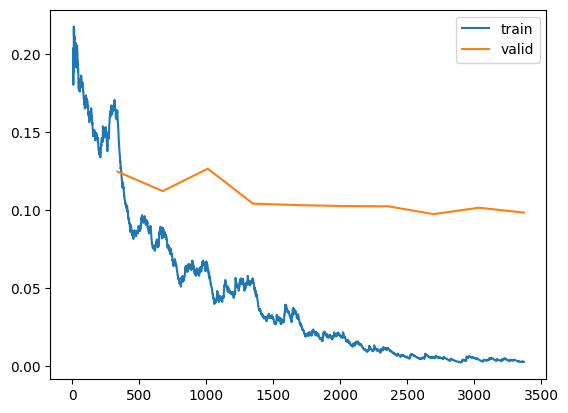

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.summary()

Sequential (Input shape: 64 x 13 x 64 x 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 32 x 32   
Conv2d                                    40768      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 16 x 16   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                   

In [ ]:
learn.fit_one_cycle(20, lr_max=slice(3e-3, 6e-6), cbs=[SaveModelCallback(monitor='accuracy',fname='euronet-resnet50-stage2')])

epoch,train_loss,valid_loss,accuracy,time
0,0.035239,0.170115,0.959259,00:44
1,0.154670,0.230367,0.944815,00:44
2,0.207444,0.338804,0.908889,00:44
3,0.170779,0.218512,0.938704,00:44
4,0.176847,0.216765,0.937593,00:44
5,0.159534,0.193209,0.940926,00:44
6,0.120023,0.179367,0.944444,00:44
7,0.095654,0.156686,0.953148,00:44
8,0.069015,0.181001,0.948519,00:44
9,0.053350,0.164088,0.952222,00:44


Better model found at epoch 0 with accuracy value: 0.9592592716217041.
Better model found at epoch 10 with accuracy value: 0.9646296501159668.
Better model found at epoch 11 with accuracy value: 0.9729629755020142.
Better model found at epoch 13 with accuracy value: 0.9731481671333313.
Better model found at epoch 14 with accuracy value: 0.976111114025116.
Better model found at epoch 15 with accuracy value: 0.9768518805503845.
Better model found at epoch 16 with accuracy value: 0.9775925874710083.
Better model found at epoch 17 with accuracy value: 0.9794444441795349.
Better model found at epoch 18 with accuracy value: 0.9801852107048035.


## Post training (error analysis and setting up for inference)

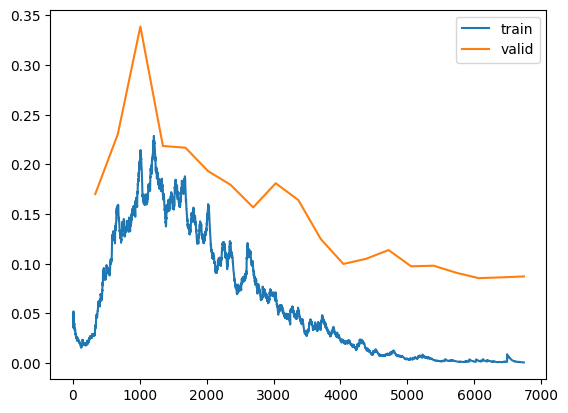

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('euronet-resnet50-stage2-final')

Path('models/euronet-resnet50-stage2-final.pth')

In [ ]:
learn.validate()

(#2) [0.08627868443727493,0.9801852107048035]

In [ ]:
interp = fv.ClassificationInterpretation.from_learner(learn)

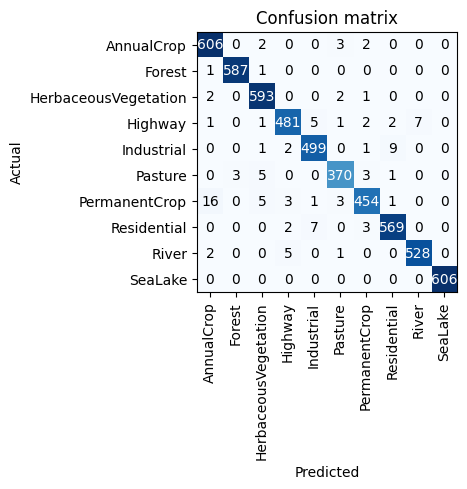

In [ ]:
interp.plot_confusion_matrix()

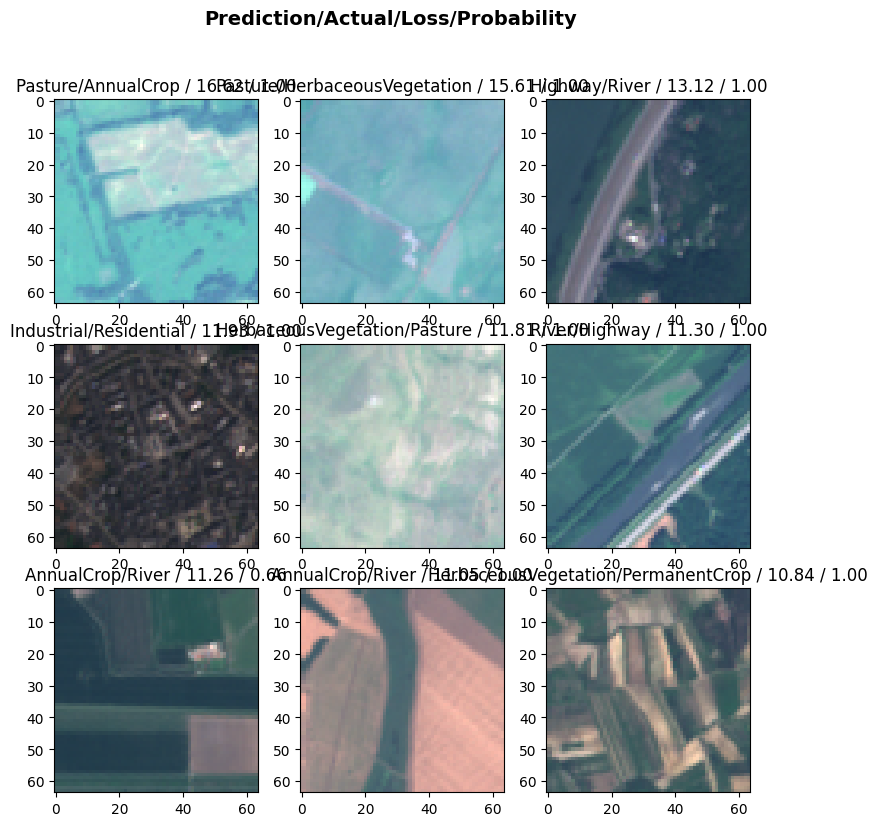

In [ ]:
interp.plot_top_losses(9)